# Bank Customer Churn - Deep Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
!pip install opendatasets
import opendatasets as od

#Fetching data from kaggle
dataset_url = 'https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset'

od.download(dataset_url)

Skipping, found downloaded files in "./bank-customer-churn-dataset" (use force=True to force download)


In [3]:
#Load the dataset
data = pd.read_csv('bank-customer-churn-dataset/Bank Customer Churn Prediction.csv')
print(data.shape)

(10000, 12)


In [4]:
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Preprocessing

In [5]:
data.drop(['customer_id'], axis=1, inplace=True)

In [6]:
data = pd.get_dummies(data=data,columns=['country','gender'],drop_first=True)

In [7]:
cols_to_scale = ['credit_score','balance','estimated_salary']

scaler = MinMaxScaler()

data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

In [8]:
data[cols_to_scale] = data[cols_to_scale].round(2)

In [9]:
#data.replace([np.inf, -np.inf], np.nan, inplace=True)
#data[cols_to_scale] = data[cols_to_scale].fillna(data[cols_to_scale].mean())

In [10]:
print(data[['country_Germany', 'country_Spain', 'gender_Male']].head())

   country_Germany  country_Spain  gender_Male
0            False          False        False
1            False           True        False
2            False          False        False
3            False          False        False
4            False           True        False


In [11]:
data[['country_Germany', 'country_Spain', 'gender_Male']] = data[['country_Germany', 'country_Spain', 'gender_Male']].astype(int)

In [12]:
data.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,0.54,42,2,0.00,1,1,1,0.51,1,0,0,0
1,0.52,41,1,0.33,1,0,1,0.56,0,0,1,0
2,0.30,42,8,0.64,3,1,0,0.57,1,0,0,0
3,0.70,39,1,0.00,2,0,0,0.47,0,0,0,0
4,1.00,43,2,0.50,1,1,1,0.40,0,0,1,0


In [13]:
print(data['churn'].value_counts())

churn
0    7963
1    2037
Name: count, dtype: int64


# Splitting data

In [14]:
X = data.drop('churn',axis=1)
y = data['churn']

In [15]:
smote = SMOTE()

X_resample,y_resample = smote.fit_resample(X,y)

In [16]:
y_resample.value_counts()

,count
churn,
1,7963
0,7963


In [17]:
X_train,X_test,y_train,y_test = train_test_split(X_resample,y_resample,test_size=0.2,random_state=1)

In [18]:
print(X_train.shape, y_test.shape)

(12740, 11) (3186,)


In [19]:
#adasyn = ADASYN(sampling_strategy='minority')
#X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [20]:
# Compute class weights for handling class imbalance
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weight_dict = dict(enumerate(class_weights))

In [21]:
#print("Class Weights: ", class_weight_dict)
#print(X_train.shape)
#print(y_train.shape)

In [22]:
print(X_train.columns)

Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'country_Germany',
       'country_Spain', 'gender_Male'],
      dtype='object')


In [23]:
X_train.reset_index(drop=True, inplace=True)
y_train = pd.Series(y_train).reset_index(drop=True)

# Model training


In [24]:
model = Sequential()

model.add(Dense(16,activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(0.1))

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [27]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5129 - loss: 1.0492 - val_accuracy: 0.6264 - val_loss: 0.6474
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5905 - loss: 0.6810 - val_accuracy: 0.6648 - val_loss: 0.6322
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6332 - loss: 0.6416 - val_accuracy: 0.6962 - val_loss: 0.6029
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6563 - loss: 0.6264 - val_accuracy: 0.7115 - val_loss: 0.5760
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6774 - loss: 0.6004 - val_accuracy: 0.7210 - val_loss: 0.5593
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7005 - loss: 0.5802 - val_accuracy: 0.7241 - val_loss: 0.5564
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7044 - loss: 0.5736 - val_accuracy: 0.7249 - val_loss: 0.5479
Epoch 8/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7156 - loss: 0.5675 - val_ac

# Model Evaluation

In [29]:
# Checking performance on unseen data to avoid overfitting
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7873 - loss: 0.4466
Test Accuracy: 0.7821720242500305


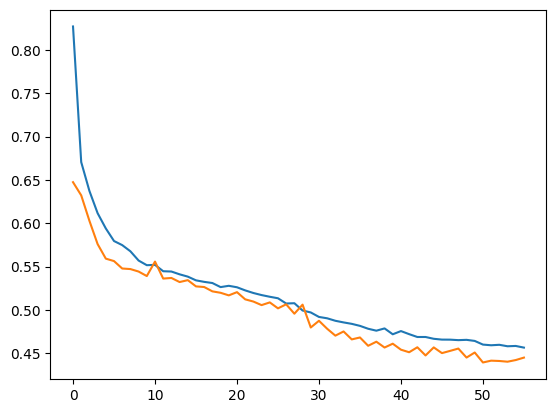

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

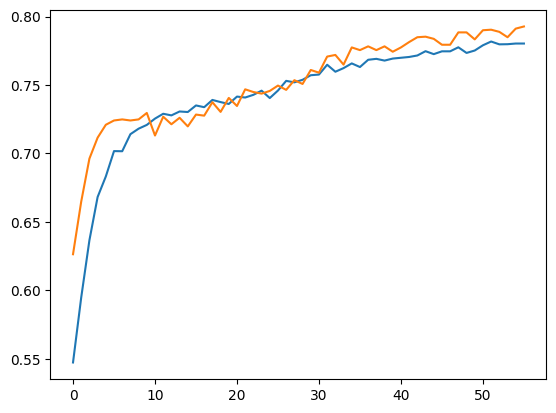

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


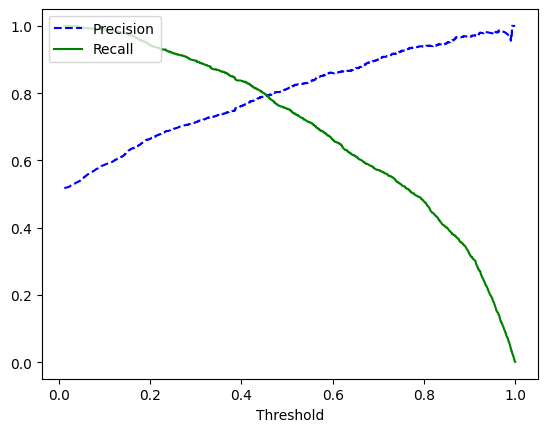

In [32]:
from sklearn.metrics import precision_recall_curve

y_pred_probs = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot to find the optimal trade-off
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend(loc="upper left")
plt.xlabel("Threshold")
plt.show()

In [33]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1534
           1       0.81      0.75      0.78      1652

    accuracy                           0.78      3186
   macro avg       0.78      0.78      0.78      3186
weighted avg       0.78      0.78      0.78      3186



In [35]:
# ROC to assess model's ability to distinguish classes
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# AUC measures overall model performance
auc_score = auc(fpr, tpr)
print(f"AUC: {auc_score}")

AUC: 0.7832464146023468


In [36]:
# Create comparison to identify mispredictions
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.ravel()})

mismatches = comparison_df[comparison_df['Actual'] != comparison_df['Predicted']]
print("Mismatched Predictions:")
print(mismatches)

Mismatched Predictions:
       Actual  Predicted
3964        1          0
8578        0          1
4429        1          0
12466       1          0
15244       1          0
...       ...        ...
3449        0          1
9126        1          0
1454        1          0
12336       1          0
14384       1          0

[694 rows x 2 columns]


In [37]:
# Align X_test with y_test to keep index consistency
X_test = pd.DataFrame(X_test, index=y_test.index)

# Investigate features of mispredicted samples
mismatched_data = X_test.loc[mismatches.index]
print(mismatched_data.describe())

       credit_score         age      tenure     balance  products_number  \
count    694.000000  694.000000  694.000000  694.000000       694.000000   
mean       0.590230   39.355908    4.906340    0.377097         1.344380   
std        0.189121    9.691422    2.837827    0.220990         0.527311   
min        0.022270   18.000000    0.000000    0.000000         1.000000   
25%        0.466827   33.000000    3.000000    0.231046         1.000000   
50%        0.600000   38.000000    5.000000    0.439869         1.000000   
75%        0.720000   45.000000    7.000000    0.527285         2.000000   
max        1.000000   83.000000   10.000000    0.890000         3.000000   

       credit_card  active_member  estimated_salary  country_Germany  \
count   694.000000     694.000000        694.000000       694.000000   
mean      0.691643       0.422190          0.502336         0.259366   
std       0.462148       0.494265          0.268338         0.438603   
min       0.000000       0.

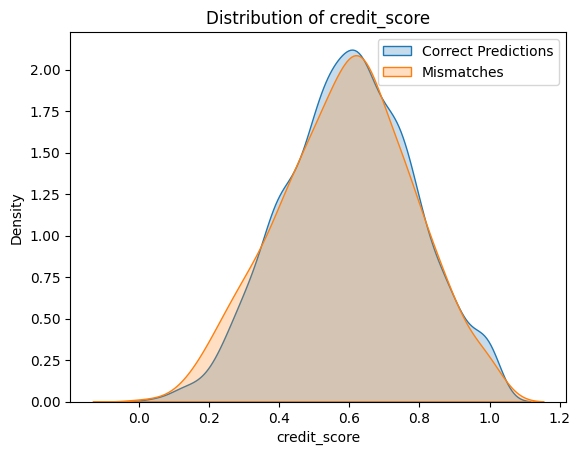

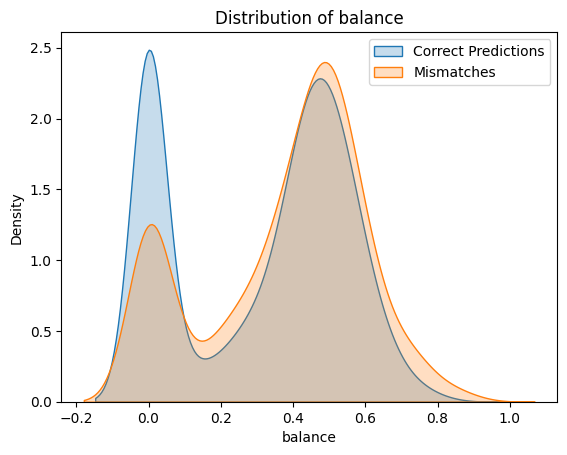

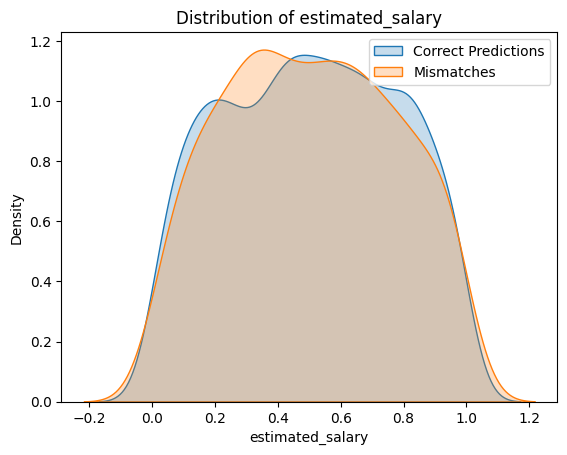

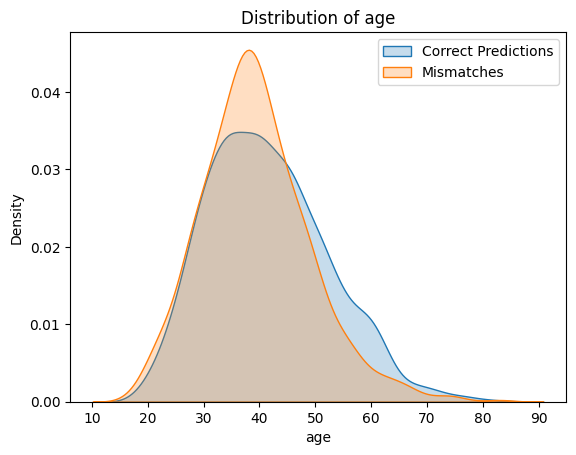

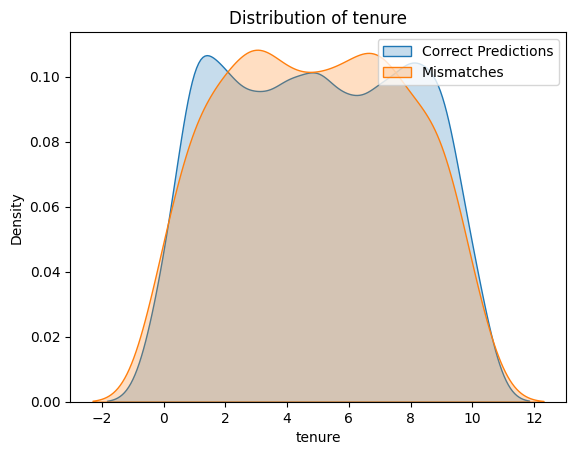

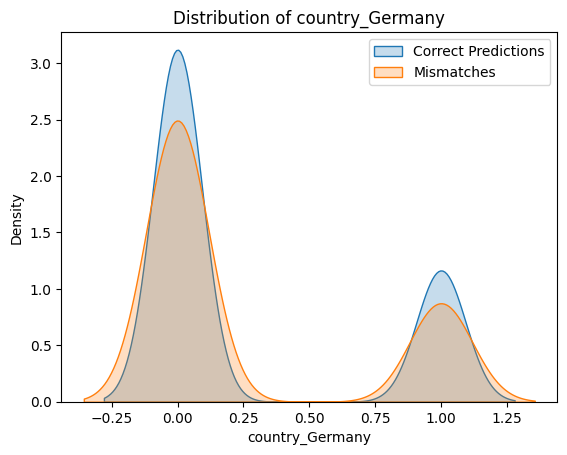

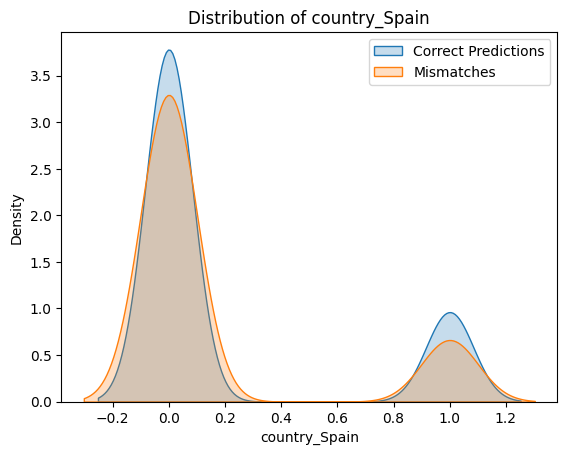

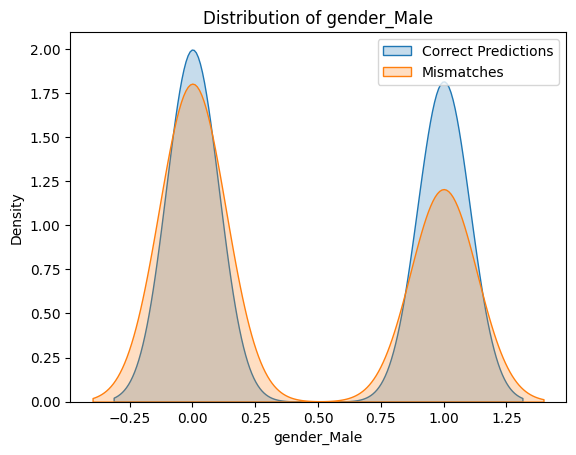

In [38]:
# Focus on correctly predicted samples for comparison
correct_matches = X_test.loc[~X_test.index.isin(mismatches.index)]

# Compare feature distributions to identify patterns in correct vs incorrect predictions
for feature in ['credit_score', 'balance', 'estimated_salary', 'age', 'tenure', 'country_Germany', 'country_Spain', 'gender_Male']:
    plt.figure()
    sns.kdeplot(correct_matches[feature], label='Correct Predictions', fill=True)
    sns.kdeplot(mismatched_data[feature], label='Mismatches', fill=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()


In [39]:
from scipy.stats import ks_2samp

# KS test to compare feature distributions
for feature in ['credit_score', 'balance', 'estimated_salary', 'age', 'tenure', 'country_Germany', 'country_Spain', 'gender_Male']:
    stat, p_value = ks_2samp(correct_matches[feature], mismatched_data[feature])
    print(f"KS Test for {feature}: Statistic={stat}, p-value={p_value}")


KS Test for credit_score: Statistic=0.0324993870876719, p-value=0.6010514261756358
KS Test for balance: Statistic=0.13179118423913294, p-value=1.1049516586552873e-08
KS Test for estimated_salary: Statistic=0.023974123535370824, p-value=0.9049147826566485
KS Test for age: Statistic=0.10908683001743909, p-value=4.396322042209039e-06
KS Test for tenure: Statistic=0.03595945064552389, p-value=0.4711622158318817
KS Test for country_Germany: Statistic=0.012303347657749757, p-value=0.9999942004729767
KS Test for country_Spain: Statistic=0.03550150105698466, p-value=0.48763357543224867
KS Test for gender_Male: Statistic=0.07574786868411193, p-value=0.003698775051904464


**KS Test Summary:**

The KS test results indicate significant differences between correct predictions and mismatches for certain variables. The balance variable has a very low p-value (1.10e-08), and age has a p-value of 4.40e-06, suggesting the model may struggle to handle these features consistently.

However, variables like credit_score, estimated_salary, tenure, and country indicators (country_Germany and country_Spain) appear to be handled more consistently by the model, as these have high p-values, indicating no statistically significant differences between correct and incorrect predictions.

# Comparison of Feature Bins

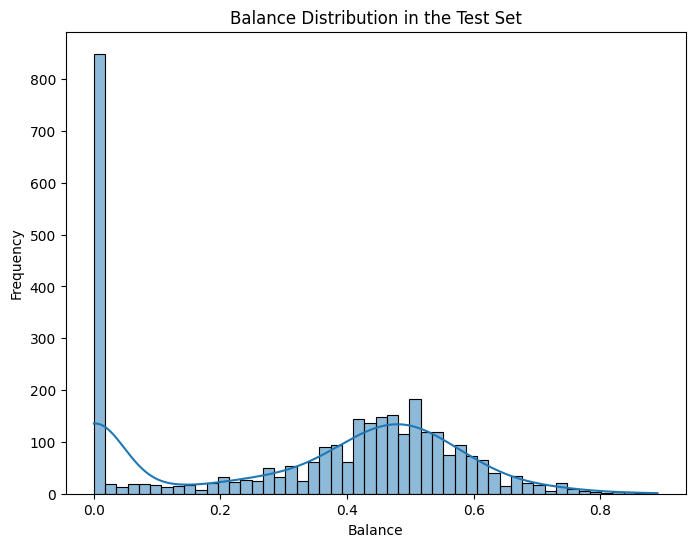

In [40]:
# Visualize balance distribution to spot patterns
plt.figure(figsize=(8, 6))
sns.histplot(X_test['balance'], bins=50, kde=True)
plt.title('Balance Distribution in the Test Set')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

# Distribution of Balance Bins

<ipython-input-41-7be773b74827>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_matches.loc[correct_matches.index, 'balance_bin'] = balance_bins.loc[correct_matches.index]


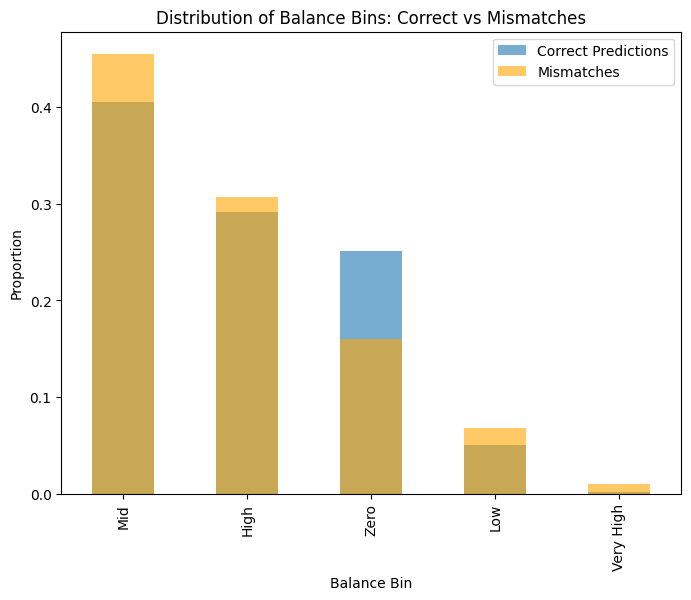

In [41]:
balance_bins = pd.cut(X_test['balance'], bins=[-1, 0, 0.2, 0.5, 0.8, np.inf], labels=['Zero', 'Low', 'Mid', 'High', 'Very High'])

balance_bins = balance_bins.astype(str)
correct_matches.loc[correct_matches.index, 'balance_bin'] = balance_bins.loc[correct_matches.index]
mismatched_data.loc[mismatched_data.index, 'balance_bin'] = balance_bins.loc[mismatched_data.index]

# Plot the new balance bin distribution
plt.figure(figsize=(8, 6))
correct_matches['balance_bin'].value_counts(normalize=True).plot(kind='bar', alpha=0.6, label='Correct Predictions')
mismatched_data['balance_bin'].value_counts(normalize=True).plot(kind='bar', alpha=0.6, color='orange', label='Mismatches')
plt.title('Distribution of Balance Bins: Correct vs Mismatches')
plt.xlabel('Balance Bin')
plt.ylabel('Proportion')
plt.legend()
plt.show()

The model is struggling the most with customers in the Mid (0.2 - 0.5) and High (0.5 - 0.8) balance ranges, where most of the misclassifications happen. For customers with Zero balance, the model performs better, but there are still some errors. In the Low balance group (0 - 0.2), there are fewer customers, but the misclassification rate is higher than correct predictions. Finally, in the Very High balance group (above 0.8), most customers are misclassified, but there aren't many examples in this group, which might be why the model is struggling here.

# Distribution of Age Bins

<ipython-input-42-cffcfe97ae09>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_matches.loc[correct_matches.index, 'age_bin'] = age_bins.loc[correct_matches.index]


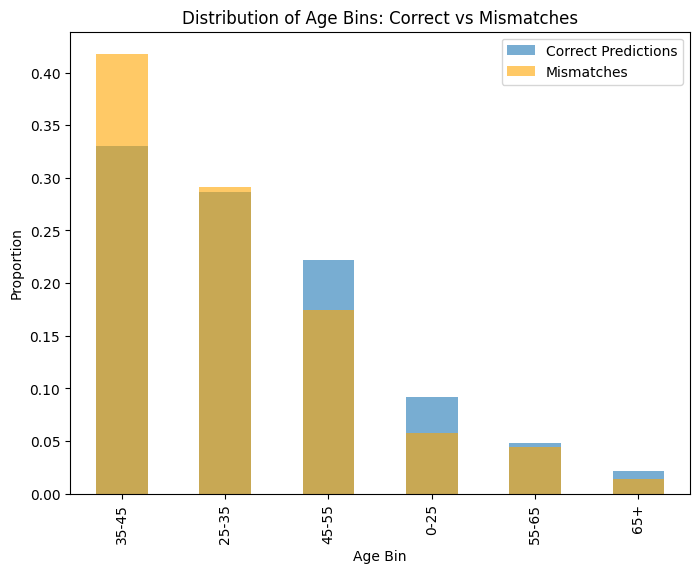

In [42]:
age_bins = pd.cut(X_test['age'], bins=[0, 25, 35, 45, 55, 65, np.inf], labels=['0-25', '25-35', '35-45', '45-55', '55-65', '65+'])

age_bins = age_bins.astype(str)

correct_matches.loc[correct_matches.index, 'age_bin'] = age_bins.loc[correct_matches.index]
mismatched_data.loc[mismatched_data.index, 'age_bin'] = age_bins.loc[mismatched_data.index]

# Plot the distribution of age bins for correct and incorrect predictions
plt.figure(figsize=(8, 6))
correct_matches['age_bin'].value_counts(normalize=True).plot(kind='bar', alpha=0.6, label='Correct Predictions')
mismatched_data['age_bin'].value_counts(normalize=True).plot(kind='bar', alpha=0.6, color='orange', label='Mismatches')
plt.title('Distribution of Age Bins: Correct vs Mismatches')
plt.xlabel('Age Bin')
plt.ylabel('Proportion')
plt.legend()
plt.show()

The model struggles the most with 35-45 years customers, where the majority of misclassifications occur. There are also significant errors in the 25-35 years and 45-55 years age groups, though the model does a bit better here. The model performs relatively well for younger (0-25 years) and older (55+ years) customers, with fewer mistakes in these age ranges. Overall, the model's performance improves as customers get older, particularly for those aged 55 and above.


# Permutation Feature Importance

In [43]:
from sklearn.metrics import accuracy_score

baseline_accuracy = accuracy_score(y_test, np.round(y_pred))

# Function to calculate permutation importance
def permutation_importance(model, X_test, y_test, metric_fn):
    feature_importances = []
    for i in range(X_test.shape[1]):
        X_permuted = X_test.copy()
        X_permuted.iloc[:, i] = np.random.permutation(X_permuted.iloc[:, i])

        # Recalculate accuracy with shuffled feature
        y_permuted_pred = model.predict(X_permuted)
        permuted_accuracy = metric_fn(y_test, np.round(y_permuted_pred))

        # Calculate drop in accuracy (importance)
        importance = baseline_accuracy - permuted_accuracy
        feature_importances.append(importance)

    return np.array(feature_importances)

# Calculate feature importance using accuracy
feature_importances = permutation_importance(model, X_test, y_test, accuracy_score)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [44]:
# Print importance scores for each feature
feature_names = X_train.columns
for i, importance in enumerate(feature_importances):
    print(f"Feature {i} ({feature_names[i]}): {importance}")

Feature 0 (credit_score): -0.003452605147520438
Feature 1 (age): 0.0662272441933458
Feature 2 (tenure): -0.0003138731952291307
Feature 3 (balance): 0.00502197112366598
Feature 4 (products_number): 0.09290646578782169
Feature 5 (credit_card): 0.0028248587570620654
Feature 6 (active_member): 0.05932203389830504
Feature 7 (estimated_salary): 0.0009416195856872811
Feature 8 (country_Germany): 0.005963590709353372
Feature 9 (country_Spain): 0.00470809792843685
Feature 10 (gender_Male): 0.02322661644695534


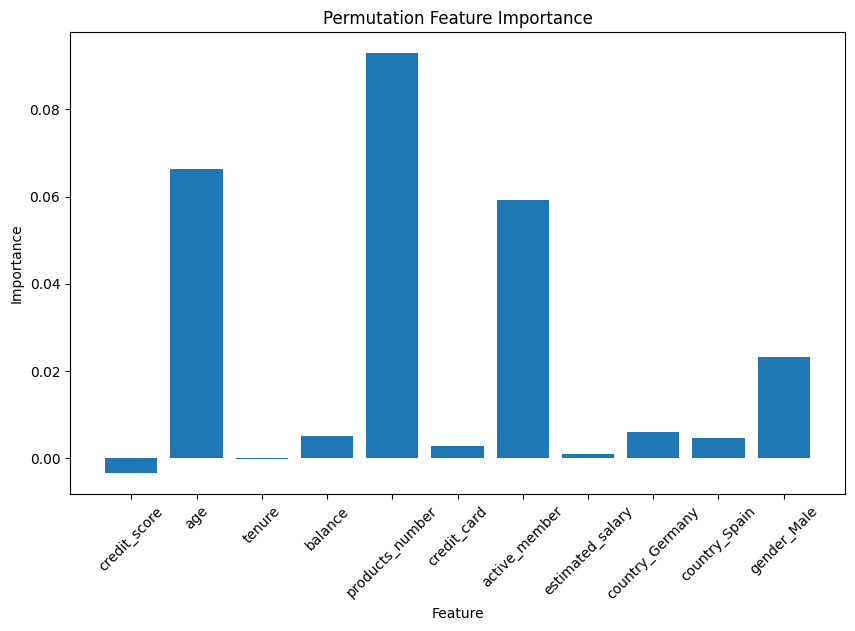

In [45]:
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.xticks(rotation=45)
plt.show()

- Products Number has the highest importance, meaning that the number of products a customer has plays a crucial role in determining the model's predictions.

- Age and Active Member are the next most important features, suggesting that customer age and whether they are actively engaged with the bank are significant factors in predicting outcomes.

- Balance and Gender (Male) also have some importance, though less than the top features, indicating that they still contribute meaningfully to the model's predictions.

- Country_Germany, Country_Spain, and Tenure have relatively low importance, indicating that these features may not strongly affect the model's decision-making.

- Estimated Salary has virtually no importance in the model's predictions, suggesting that salary does not significantly impact the model's outcomes.

In [47]:
from google.colab import files
import joblib

model.save('bank_churn.keras')
files.download('bank_churn.keras')

joblib.dump(scaler, 'minmax_scaler.pkl')
files.download('minmax_scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>